<a href="https://colab.research.google.com/github/fernandofsilva/desafio-alelo/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

## Setup

In [1]:
# Data handling
import pandas as pd
import numpy as np
from collections import defaultdict

# Modules for feature engineering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import silhouette_score

# Plot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Load data and merge

In [2]:
# Characters powers
powers = pd.read_csv("drive/MyDrive/Datasets/super_hero_powers.csv")

# Characters information
info = pd.read_csv(
    "drive/MyDrive/Datasets/heroes_information.csv",
    index_col=0, 
    na_values=['-', -99.0]
)

# Merge databases
data = info.merge(right=powers, how='inner', left_on='name', right_on='hero_names')

## Feature Engineering

### Class for variable selection

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

### Define columns according to each

In [5]:
# Categorical columns name
categorical = list(info.select_dtypes('object').columns)[1:]

# Numeric columns name
numerical = list(info.select_dtypes('number').columns)

# Boolean columns name
boolean = list(powers.select_dtypes('bool').columns)

### Construct feature engineering graph

In [6]:
# Define categorical pipeline
cat_pipe = Pipeline(
    [('selector', ColumnSelector(categorical)),
     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline(
    [('selector', ColumnSelector(numerical)),
     ('imputer', SimpleImputer(strategy='median')),
     ('scaler', StandardScaler())])

# Define boolean pipeline
bool_pipe = Pipeline(
    [('selector', ColumnSelector(boolean)),
     ('pca', PCA(n_components=0.95))])

# Fit column transformer to training data
preprocessor = FeatureUnion(
    [('categorical', cat_pipe),
     ('numerical', num_pipe),
     ('boolean', bool_pipe)])

## Model

### KMeans

#### Elbow Method

In [7]:
results = defaultdict(list)

for n in range(2, 50):

    # Combine categorical and numerical pipeline with the model
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', KMeans(n_clusters=n, random_state=0))
    ])

    # Fit the model
    model.fit(data)

    # Append results
    results['cluster'].append(n)
    results['distance'].append(model.named_steps['model'].inertia_)

# Convert to pd.DataFrame
results = pd.DataFrame(results)

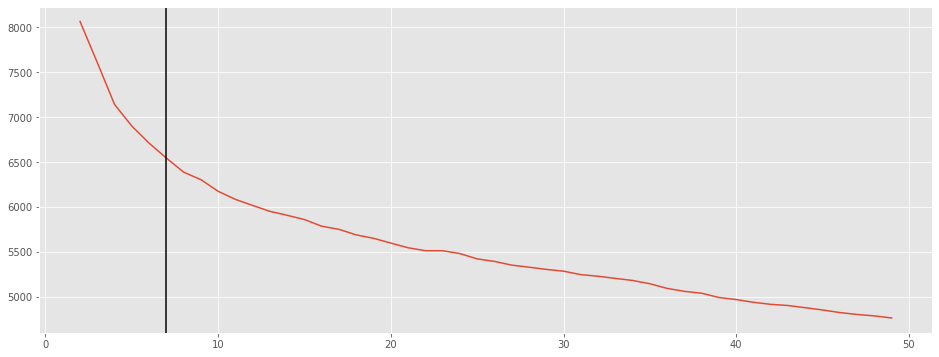

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(results['cluster'], results['distance'])
ax.axvline(x=7, color='black')
plt.show()

### DBSCAN

#### Nearest Neighbors

In [9]:
nn_model = Pipeline([('preprocessor', preprocessor), ('model', NearestNeighbors(n_neighbors=2))])
nns = nn_model.fit(data)
transformed_data = preprocessor.transform(data)
distances, indices = nns.named_steps['model'].kneighbors(transformed_data)

In [10]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

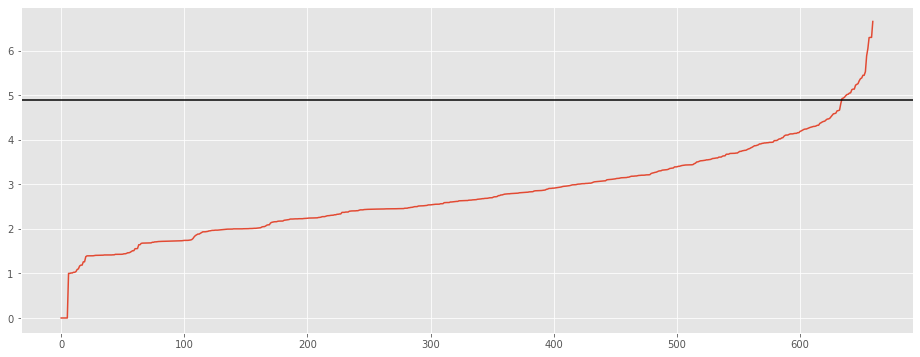

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(distances)
ax.axhline(y=4.9, color='black')
plt.show()

## Metrics


### Silhoette Score

In [12]:
pipe = Pipeline([('preprocessor', preprocessor), ('model', KMeans(n_clusters=7, random_state=0))])
kmeans_clusters = pipe.fit_predict(data)
silhouette_kmeans = silhouette_score(transformed_data, kmeans_clusters)

In [13]:
pipe = Pipeline([('preprocessor', preprocessor), ('model', DBSCAN(eps=5, min_samples=3))])
dbscan_clusters = pipe.fit_predict(data)
silhouette_dbscan = silhouette_score(transformed_data, dbscan_clusters)

#### t-SNE visualisation

In [14]:
model = Pipeline([('preprocessor', preprocessor), ('model', TSNE(perplexity=35))])
tsne_results = model.fit_transform(data)

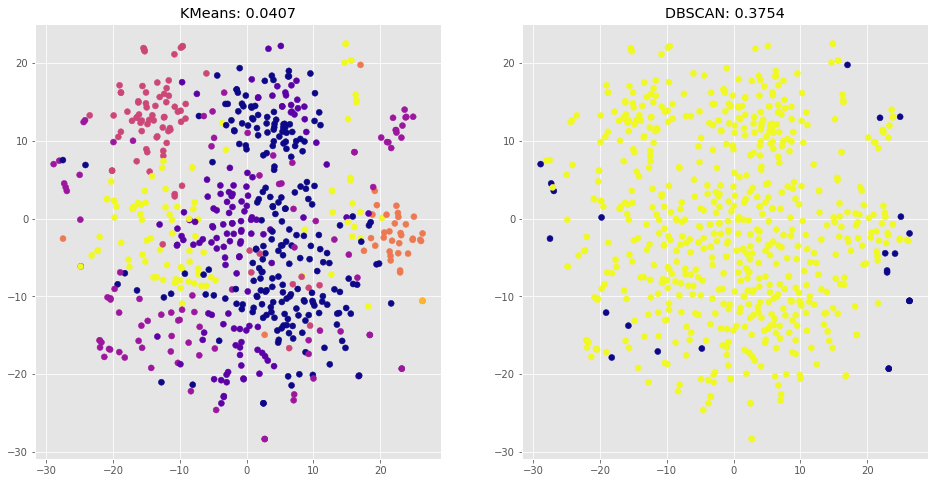

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.scatter(tsne_results[:,0], tsne_results[:,1], c=kmeans_clusters, cmap='plasma')
ax1.set_title(f"KMeans: {silhouette_kmeans:.4f}")
ax2.scatter(tsne_results[:,0], tsne_results[:,1], c=dbscan_clusters, cmap='plasma')
ax2.set_title(f"DBSCAN: {silhouette_dbscan:.4f}")
plt.show()